In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
public_data = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/public_data.xlsx')
private_data2123 = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/private_2123.xlsx')
private_data2324 = pd.read_excel('../Data/BCW Public and Private Original Data/Raw Excel Public and Private Data/private_2324.xlsx')

private_data = pd.concat([private_data2123, private_data2324])

private_data['Date of WW\nRelease'] = pd.to_datetime(private_data['Date of WW\nRelease'], errors='coerce') \
                         .apply(lambda x: x.isoformat() if pd.notnull(x) else None)

private_data.rename(
    columns={
        'Location of Private Lateral': 'location',
        'Date of WW\nRelease': 'Date'
    },
    inplace=True
)
private_data.head()

,location,Zipcode,Date,lat,long
0,"4738 Kinglet St, Houston, Texas, 77035",77035.0,2021-04-01T00:00:00,29.660417,-95.458553
1,"12426 Frazier River Dr, Houston, Texas, 77050",77050.0,2021-04-01T00:00:00,29.903616,-95.294957
2,"275 Georgia St, Houston, Texas, 77029",77029.0,2021-04-01T00:00:00,29.742243,-95.257936
3,"9406 Bertwood St, Houston, Texas, 77016",77016.0,2021-04-01T00:00:00,29.847411,-95.309740
4,"110 Zachary St, Houston, Texas, 77029",77029.0,2021-04-01T00:00:00,29.738707,-95.262914


In [3]:
public_data['Start_Date'] = pd.to_datetime(public_data['Start_Date'], errors='coerce') \
                         .apply(lambda x: x.isoformat() if pd.notnull(x) else None)

public_data = public_data[['Address', 'Zipcode', 'Start_Date', 'lat', 'long']]

public_data.rename(
    columns={
        'Address': 'location',
        'Start_Date': 'Date'
    },
    inplace=True
)
public_data.head()

,location,Zipcode,Date,lat,long
0,8515 HAMMERLY BLVD,77055.0,2021-04-01T00:00:00,29.810848,-95.499751
1,7206 LA PASEO ST,77087.0,2021-04-01T00:00:00,29.678630,-95.300138
2,3502 DARLINGHURST DR,77045.0,2021-04-01T00:00:00,29.624011,-95.428274
3,5411 PARDEE ST,77026.0,2021-04-01T00:00:00,29.805975,-95.316642
4,12017 PALMCREST ST,77034.0,2021-04-01T00:00:00,29.627992,-95.210625


In [4]:
private_data['Source'] = 'Private'
public_data['Source'] = 'Public'

combined_data = pd.concat([private_data, public_data], ignore_index=True)

combined_data = combined_data.dropna(subset=['Date'])

In [5]:
combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')

group_west_university = combined_data[combined_data['Zipcode'] == 77005]
group_third_ward      = combined_data[combined_data['Zipcode'] == 77003]
group_ost             = combined_data[combined_data['Zipcode'] == 77021]
group_fifth_ward      = combined_data[combined_data['Zipcode'].isin([77026, 77020])]


In [6]:
def average_time_between_events(df):
    df_sorted = df.sort_values('Date')
    time_diffs = df_sorted['Date'].diff().dropna()
    return time_diffs.mean()

avg_diff_west   = average_time_between_events(group_west_university)
avg_diff_third  = average_time_between_events(group_third_ward)
avg_diff_ost    = average_time_between_events(group_ost)
avg_diff_fifth  = average_time_between_events(group_fifth_ward)


In [7]:
print("Average Time Between Events:")
print("West University (77005):", avg_diff_west)
print("Third Ward (77003):", avg_diff_third)
print("OST/South Union (77021):", avg_diff_ost)
print("Fifth Ward (77026, 77020):", avg_diff_fifth)

Average Time Between Events:
West University (77005): 60 days 18:00:00
Third Ward (77003): 10 days 16:04:56.907216494
OST/South Union (77021): 5 days 01:49:05.454545454
Fifth Ward (77026, 77020): 2 days 02:17:00.242914979


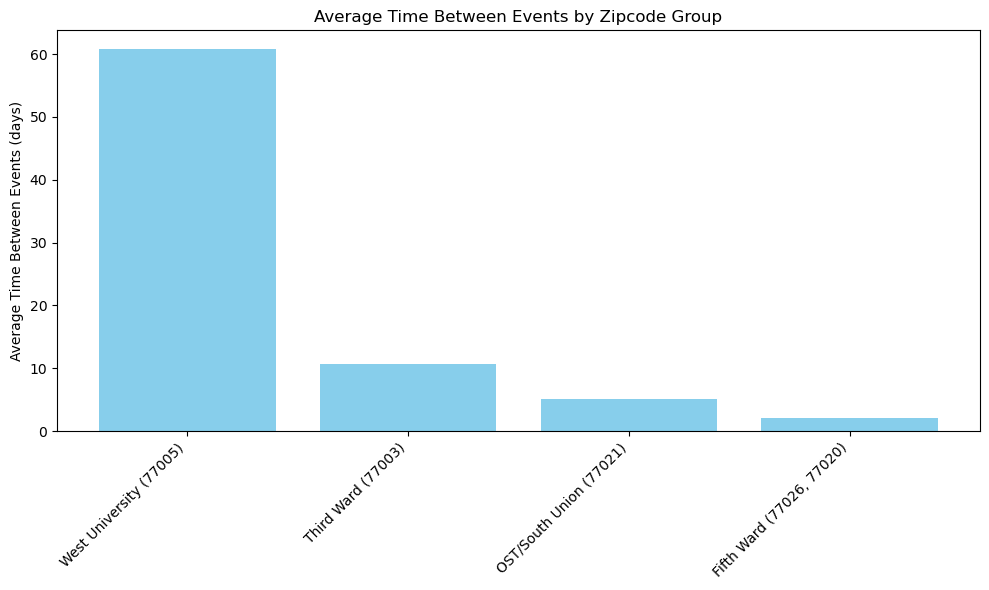

In [8]:
avg_west_days = avg_diff_west.total_seconds() / 86400
avg_third_days = avg_diff_third.total_seconds() / 86400
avg_ost_days = avg_diff_ost.total_seconds() / 86400
avg_fifth_days = avg_diff_fifth.total_seconds() / 86400

# Create a dictionary for plotting
avg_days = {
    'West University (77005)': avg_west_days,
    'Third Ward (77003)': avg_third_days,
    'OST/South Union (77021)': avg_ost_days,
    'Fifth Ward (77026, 77020)': avg_fifth_days
}

# Prepare data for the bar chart
groups = list(avg_days.keys())
values = list(avg_days.values())

plt.figure(figsize=(10, 6))
plt.bar(groups, values, color='skyblue')
plt.ylabel('Average Time Between Events (days)')
plt.title('Average Time Between Events by Zipcode Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

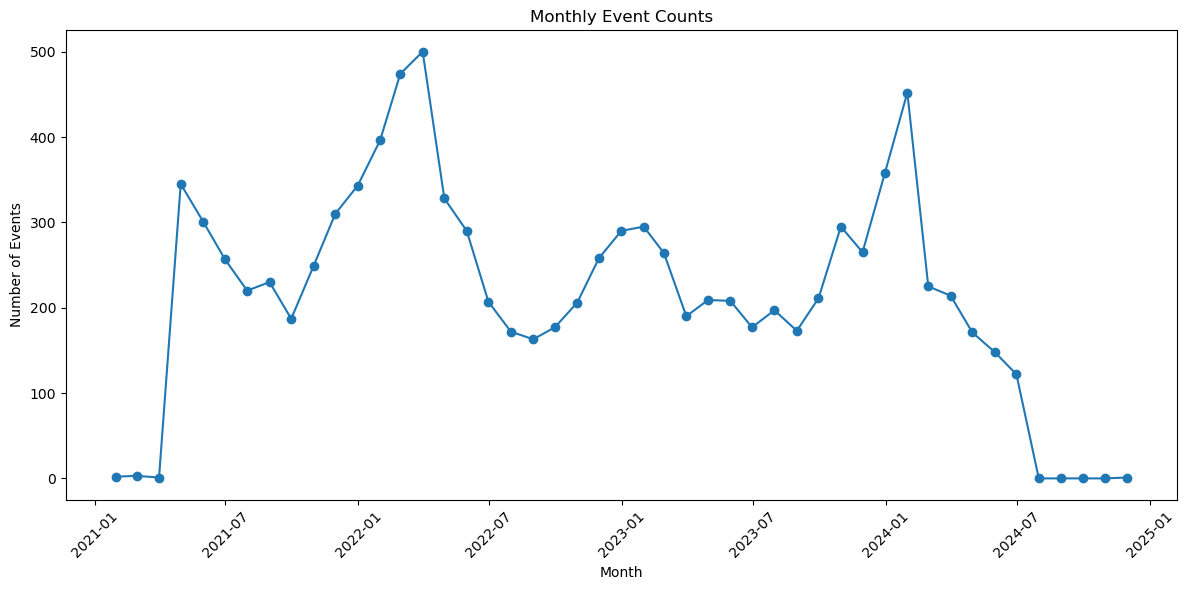

In [10]:
monthly_counts = combined_data.resample('M', on='Date').size()


plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title("Monthly Event Counts")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



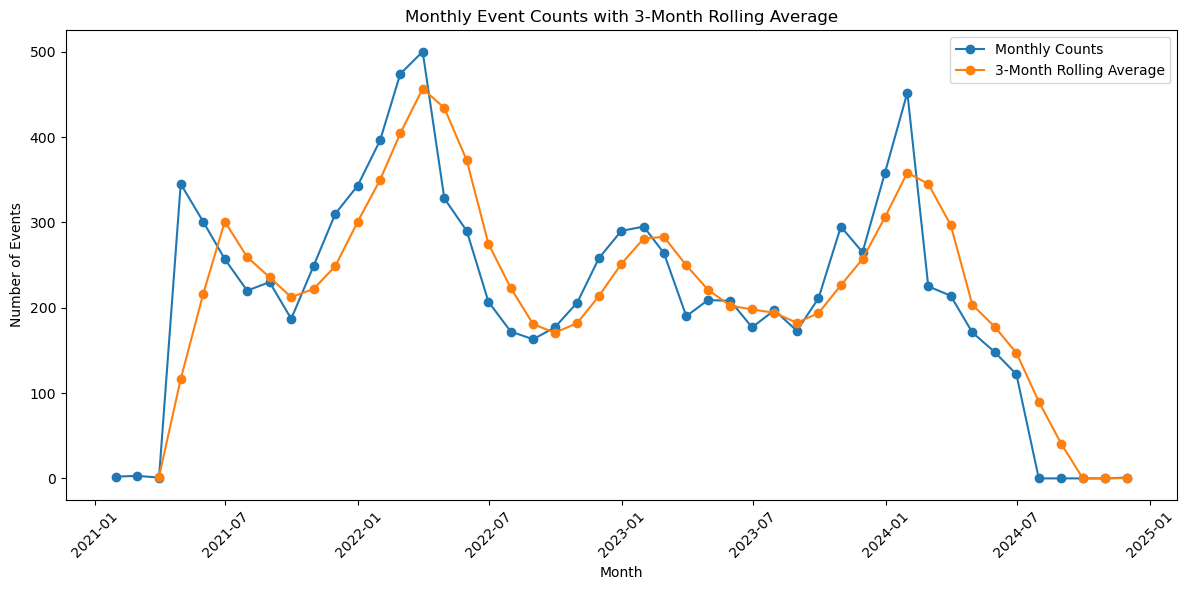

In [11]:
rolling_mean = monthly_counts.rolling(window=3).mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', label='Monthly Counts')
plt.plot(rolling_mean.index, rolling_mean.values, marker='o', label='3-Month Rolling Average')
plt.title("Monthly Event Counts with 3-Month Rolling Average")
plt.xlabel("Month")
plt.ylabel("Number of Events")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


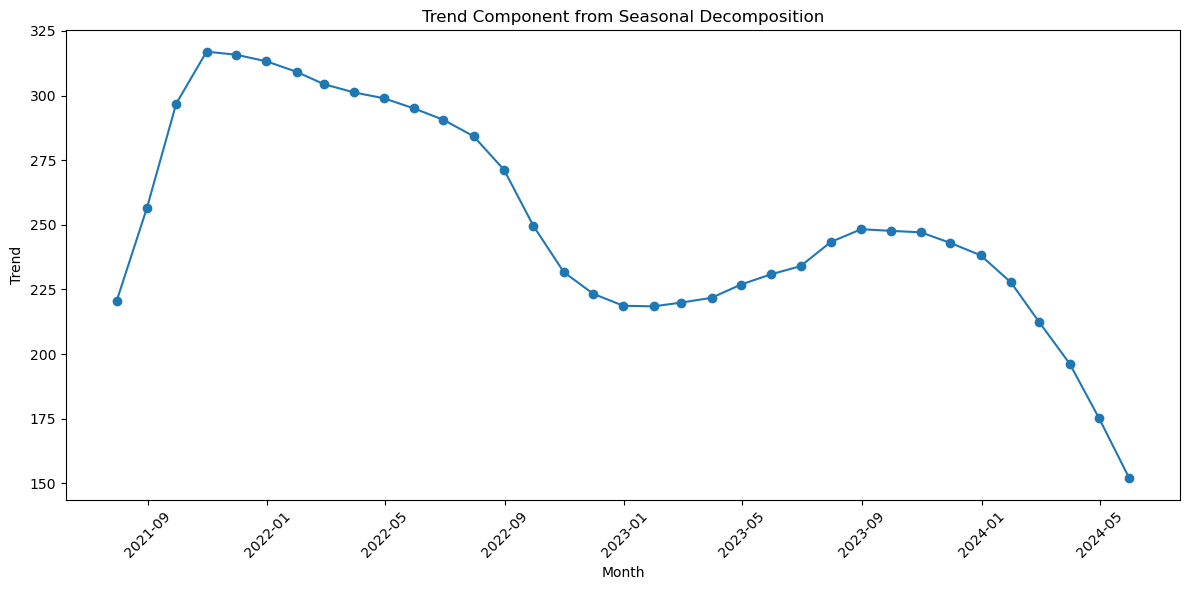

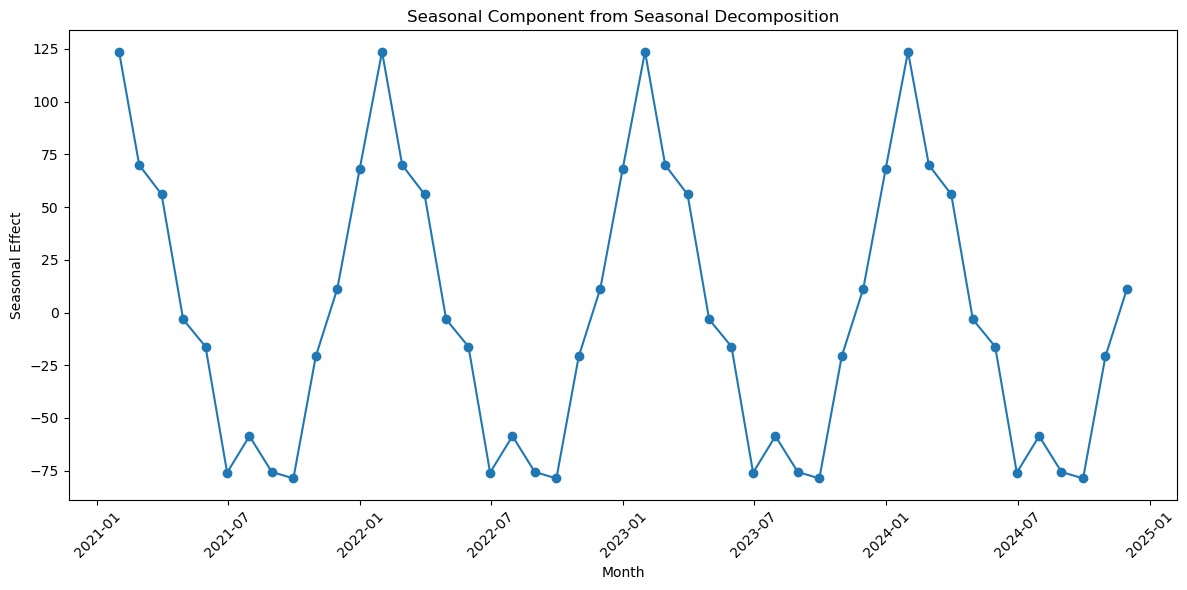

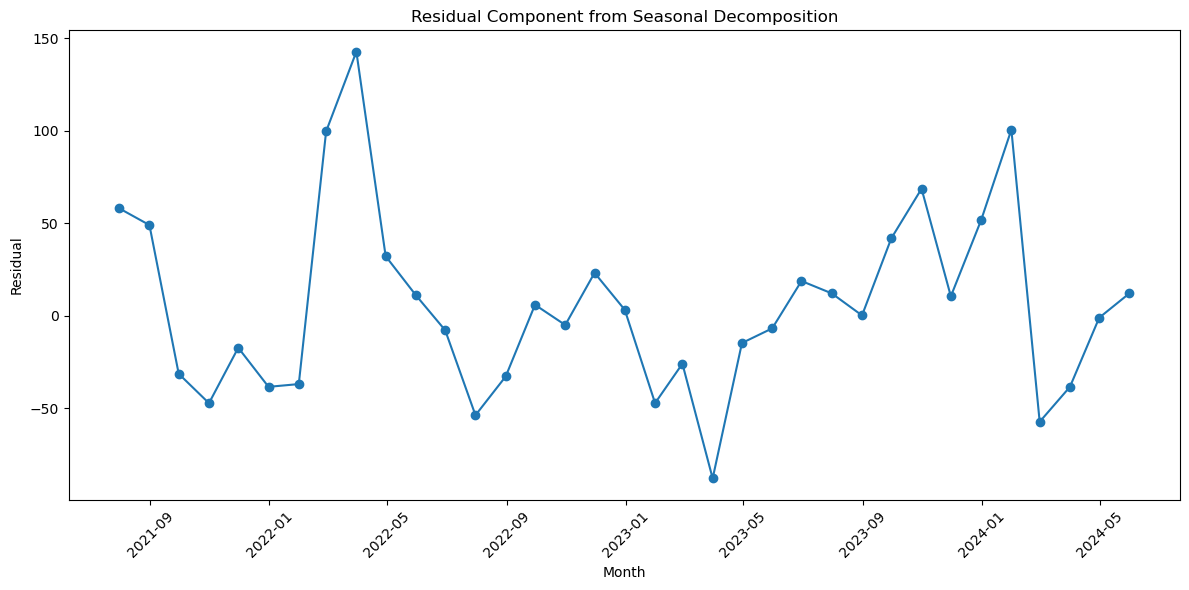

In [12]:

decomposition = seasonal_decompose(monthly_counts, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot Trend Component
plt.figure(figsize=(12, 6))
plt.plot(trend.index, trend.values, marker='o')
plt.title("Trend Component from Seasonal Decomposition")
plt.xlabel("Month")
plt.ylabel("Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Seasonal Component
plt.figure(figsize=(12, 6))
plt.plot(seasonal.index, seasonal.values, marker='o')
plt.title("Seasonal Component from Seasonal Decomposition")
plt.xlabel("Month")
plt.ylabel("Seasonal Effect")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Residual Component
plt.figure(figsize=(12, 6))
plt.plot(residual.index, residual.values, marker='o')
plt.title("Residual Component from Seasonal Decomposition")
plt.xlabel("Month")
plt.ylabel("Residual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2]:
three_data = pd.read_csv('../311_data_clean/combined_sorted_output.csv', low_memory=False)

three_data.head()


,365 Case Number,Case Number,Incident Address,Latitude,Longitude,Status,Created Date Local,Closed Date,Title,Incident Case Type,...,Heavy Trash Quadrant,Queue,ETJ,SLA Name,Channel,Extract Date,Latest Case Notes,Sample Case Confilcts Notes,Description,Resolution Notes
0,2200304269,20190052-2200304269,8702 OTHELLO ST Houston Texas 77029,29.7608,-95.2697,Service Completed,2021-12-31T18:14:20,2022-04-19T17:17:00,Sewer Wastewater - 20190052-2200304269 - 8702 ...,Sewer Wastewater,...,NE,NaN,FULL,1 Calendar Day Deactivated,Phone,2024-11-04 22:01:03.7200000,Private problem,NaN,sewer issue,Private problem
1,2200304282,20190053-2200304282,8407 SULTAN DR Houston Texas 77078,29.8382,-95.2542,Service Completed,2021-12-31T18:44:19,2022-01-01T10:58:00,Sewer Wastewater - 20190053-2200304282 - 8407 ...,Sewer Wastewater,...,NE,NaN,FULL,1 Calendar Day Deactivated,Email,2024-11-04 22:01:03.7200000,1/1/2022 10:58:24 AM - Case # 20190053 -220030...,NaN,manhole FB018060,1/1/2022 10:58:24 AM - Case # 20190053 -220030...
2,2200304291,20190055-2200304291,1005 ROSEPOINT ST Houston Texas 77018,29.8221,-95.4251,Service Completed,2021-12-31T19:34:16,2022-01-02T17:48:00,Sewer Wastewater - 20190055-2200304291 - 1005 ...,Sewer Wastewater,...,NE,NaN,FULL,1 Calendar Day Deactivated,Phone,2024-11-04 22:01:03.7200000,1/2/2022 5:48:37 PM - Case # 20190055 -2200304...,NaN,SEWERWASTE WATER-both units are backed up also...,1/2/2022 5:48:37 PM - Case # 20190055 -2200304...
3,2200304363,20190059-2200304363,7900 HILLCROFT AVE Houston Texas 77081,29.6932,-95.4934,Service Completed,2022-01-01T08:24:52,2022-01-01T11:30:00,Sewer Wastewater - 20190059-2200304363 - 7900 ...,Sewer Wastewater,...,NaN,NaN,FULL,1 Calendar Day Deactivated,Email,2024-11-04 22:01:03.7200000,1/1/2022 11:30:35 AM - Case # 20190059 -220030...,NaN,FW: Hillcroft -SEWER LINE NO CITY SIDE STOPED ...,1/1/2022 11:30:35 AM - Case # 20190059 -220030...
4,2200304373,20190060-2200304373,9919 TANGIERS RD Houston Texas 77041,29.8460,-95.5383,Service Completed,2022-01-01T09:00:34,2022-01-02T16:22:00,Sewer Wastewater - 20190060-2200304373 - 9919 ...,Sewer Wastewater,...,NE,NaN,FULL,1 Calendar Day Deactivated,Phone,2024-11-04 22:01:03.7200000,1/2/2022 4:21:24 PM - Case # 20190060 -2200304...,NaN,overflowing inside,1/2/2022 4:21:24 PM - Case # 20190060 -2200304...


In [3]:
three_data = three_data[['Incident Address', 'Zip Code', 'Created Date Local', 'X', 'Y']]

three_data.rename(
    columns={
        'Incident Address': 'location',
        'Created Date Local': 'Date',
        'Zip Code': 'Zipcode'
    },
    inplace=True
)
three_data.head()


,location,Zipcode,Date,X,Y
0,8702 OTHELLO ST Houston Texas 77029,77029,2021-12-31T18:14:20,3.151841e+06,1.384306e+07
1,8407 SULTAN DR Houston Texas 77078,77078,2021-12-31T18:44:19,3.155859e+06,1.387133e+07
2,1005 ROSEPOINT ST Houston Texas 77018,77018,2021-12-31T19:34:16,3.101878e+06,1.386376e+07
3,7900 HILLCROFT AVE Houston Texas 77081,77081,2022-01-01T08:24:52,3.081647e+06,1.381628e+07
4,9919 TANGIERS RD Houston Texas 77041,77041,2022-01-01T09:00:34,3.065749e+06,1.387140e+07


In [7]:
three_data['Date'] = pd.to_datetime(three_data['Date'], errors='coerce')

group_west_university2= three_data[three_data['Zipcode'] == '77005']
group_third_ward2     = three_data[three_data['Zipcode'] == '77003']
group_ost2             = three_data[three_data['Zipcode'] == '77021']
group_fifth_ward2      = three_data[three_data['Zipcode'].isin(['77026', '77020'])]

In [9]:
def average_time_between_events(df):
    df_sorted = df.sort_values('Date')
    time_diffs = df_sorted['Date'].diff().dropna()
    return time_diffs.mean()
    
avg_diff_west2   = average_time_between_events(group_west_university2)
avg_diff_third2  = average_time_between_events(group_third_ward2)
avg_diff_ost2    = average_time_between_events(group_ost2)
avg_diff_fifth2  = average_time_between_events(group_fifth_ward2)

In [10]:
print("Average Time Between Events:")
print("West University (77005):", avg_diff_west2)
print("Third Ward (77003):", avg_diff_third2)
print("OST/South Union (77021):", avg_diff_ost2)
print("Fifth Ward (77026, 77020):", avg_diff_fifth2)

Average Time Between Events:
West University (77005): 9 days 22:18:22.610000
Third Ward (77003): 5 days 11:44:36.196808510
OST/South Union (77021): 1 days 10:34:44.813110181
Fifth Ward (77026, 77020): 1 days 01:52:41.020876826


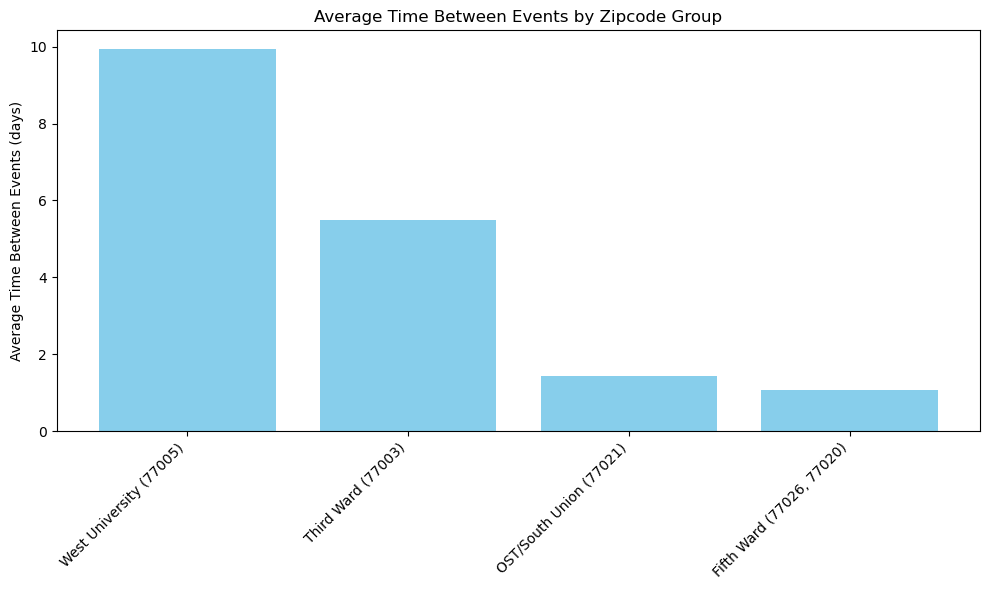

In [12]:
avg_west_days2 = avg_diff_west2.total_seconds() / 86400
avg_third_days2 = avg_diff_third2.total_seconds() / 86400
avg_ost_days2 = avg_diff_ost2.total_seconds() / 86400
avg_fifth_days2 = avg_diff_fifth2.total_seconds() / 86400

# Create a dictionary for plotting
avg_days2 = {
    'West University (77005)': avg_west_days2,
    'Third Ward (77003)': avg_third_days2,
    'OST/South Union (77021)': avg_ost_days2,
    'Fifth Ward (77026, 77020)': avg_fifth_days2
}

# Prepare data for the bar chart
groups2 = list(avg_days2.keys())
values2 = list(avg_days2.values())

plt.figure(figsize=(10, 6))
plt.bar(groups2, values2, color='skyblue')
plt.ylabel('Average Time Between Events (days)')
plt.title('Average Time Between Events by Zipcode Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()